# Demo: InterpretME over the French Royalty KG

## WHAT?

<font size=3>Interpretability of the complex machine learning models, commonly referred as black-boxes has gained tremendous attention in recent years. Understanding the decision making process is critical in domain such as healthcare.

## WHY?

<font size=3>The XAI frameworks working with KGs as opposed to tabular data is still an open research. Integrating the interpretability layer can make them reliable and trustable, and help the decision-makers to better understand the interpretation of decisions made by the trained predictive model.

## HOW?

<font size=3>Proposing an analytical tool, **InterpretME**, that integrates the data either from KGs or datasets, i.e., CSV and JSON format aiming to exploit the semantic information, prediction, interpretation as well as traversing about an entity and generate the InterpretME KG with all traced metadata about the trained model to provide the user more meaningful and trustable interpretations. 

`Overview`: This an example on how **InterpretME** can be used to interpret the prediction and trace back a particular target entity. The KG of the *French Royalty Benchmark* is a fully curated subset of DBpedia; for each person we added the class `dbo:Person` as well as different properties like the number of children or predecessors, and further triple related counts. Here, the predictive task is a binary classification to predict whether a person has a spouse. The statistics of the *French Royalty KG* are presented in the following:

| #triples | #entities | #predicates | #objects | #triples / #entities |
| :-: | :-: | :-: | :-: | :-: |
| 31,599 | 3,439 | 133 | 4,390 | 9.18 |

Importing required modules from **InterpretME** library:

* `pipeline()`: Run the predictive tasks and interpretation tools (e.g., LIME).
* `plots.sampling()`: Generates plot of the target class distribution.
* `plots.feature_importance()`: Creates bar plot of important features.
* `plots.decision_trees()`: Generates trees of predictions made by predictive model.
* `plots.constraints_decision_trees()`: Trees are incorporated with SHACL validation results.
* `federated()`: Query the *InterpretME KG* and the input KG to trace back all properties of a target entity.


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import SVG, display
import os
def show_svg(rel_path):
    if type(rel_path) == list:
        for path in rel_path:
            show_svg(path)
    else:
        display(SVG(url='file://' + os.getcwd() + '/' + rel_path))

from InterpretME import pipeline, plots

shaclAPI logger assigned!


**InterpretME** takes a JSON file as input (i.e., *URL of the input KG or path to dataset, features’ definition, target class definition, SHACL constraints, sampling strategy*); a `SPARQL query` is generated based on the feature definition given by the user and the query is used to retrieve the application domain data from the input KG.

Given the input **KG** that integrates the features’ and class target definitions about French Royalty; and their SHACL constraints. The features’ definition is classified into independent and dependent variables; later used in the predictive modeling pipeline. The features can be defined in the following format:

```JSON
{
  "Endpoint": "https://labs.tib.eu/sdm/InterpretME-og/sparql",
  "Index_var": "Person",
  "Independent_variable": {
    "x": "?x a <http://dbpedia.org/ontology/Person>.\n ",
    "gender": "Optional { ?x <http://dbpedia.org/ontology/gender> ?gender }"},
  "Dependent_variable": {
    "HasSpouse": "{ SELECT ?x, ((?partners > 0) AS ?HasSpouse) WHERE { ?x <http://dbpedia.org/ontology/numSpouses> ?partners . }} \n"}
  "Constraints": [{
    "name": "C1",
    "inverted": false,
    "shape_schema_dir": "shapes/french_royalty/spouse/rule1",
    "target_shape": "Spouse"
  }],
  "classes": {
    "NoSpouse": "0",
    "HasSpouse": "1"
  },
  "sampling_strategy": "undersampling",
  "number_important_features": 5,
  "cross_validation_folds": 5,
  "test_split": 0.3,
  "model": "Random Forest"
}
```

<div class="alert alert-info"><b>Note:</b> As of v1.2.0, InterpretME is also able to work with CSV and JSON datasets. See `example_csv_french_royalty.json` for an example configuration for datasets.</div>

The purpose of `pipeline()` is to assemble several components of **InterpretME** that can be evaluated together while setting different parameters. First, it starts with evaluating the SHACL constraints over the nodes of input KGs and generates a validation report per target entity. The *data preprocessing* step includes transforming the data extracted from the input KG into a form that can be used to train the predictive pipeline. To avoid imbalance, the sampling strategy defined by the user is deployed. The *predictive model building* step can be achieved based on user preferences. Given the French Royalty preprocessed data, automated tools are utilized for models (e.g., *Ensemble Learning*) and to optimize the hyperparameter selection (e.g., *AutoML*) for predictive tasks. Here, the automated predictive model can perform stratified shuffle split cross-validation with *Random Forest*, *Adaboost Classifier*, or *Gradient Boosting Classifier* and identify the relevant features; they are used to train a *Decision Tree* classifier to predict and visualize the outcomes. The current version of InterpretME uses *LIME* [1] to have local interpretations of the target entities. *LIME* also identifies the top-10 relevant features for the target entity and assigns weights. The traced metadata collected from the trained predictive model is later used for creation of the InterpretME KG. To incorporate the metadata gathered from the predictive pipeline into the **InterpretME KG**, RML mappings are defined. SDM-RDFizer [2], an efficient RML engine for creating knowledge graphs, semantifies the metadata using the RML mappings. InterpretME extends the ML schema vocab, it is avaiable on [VoCol](http://ontology.tib.eu/InterpretME/).  

In [2]:
results = pipeline(path_config='./example_jupyter.json', lime_results='./output/LIME')

1678800220378
SELECT ?x ?gender ?childs ?predecessors ?preds ?objects ?subjects ?HasSpouse  WHERE { ?x a <http://dbpedia.org/ontology/Person>. 
 Optional { ?x <http://dbpedia.org/ontology/gender> ?gender } .
 ?x <http://dbpedia.org/ontology/numChilds> ?childs . 
 ?x <http://dbpedia.org/ontology/numPredecessors> ?predecessors . 
?x <http://dbpedia.org/ontology/numPreds> ?preds .
?x <http://dbpedia.org/ontology/numObjects> ?objects . 
?x <http://dbpedia.org/ontology/numSubjects> ?subjects . 
{ SELECT ?x, ((?partners > 0) AS ?HasSpouse) WHERE { ?x <http://dbpedia.org/ontology/numSpouses> ?partners . }} 
}


C:\Users\ChudasamaY\Anaconda3\envs\interpretmeDemo\lib\site-packages\InterpretME\pipeline.py:162: FutureWarning: In a future version of pandas all arguments of StringMethods.rsplit except for the argument 'pat' will be keyword-only.
  df[column] = df[column].str.rsplit('/', 1).str[-1]


Number of unique nodes: 2212
Skip adding filter clause because no checker instance is provided.
Validating ./shapes/french_royalty/spouse/rule10 for targets ['<http://example.org/Spouse>']
Total execution time:  9  ms
Number of validated targets: ./shapes/french_royalty/spouse/rule10_<http://example.org/Spouse>    176
dtype: int64
Skip adding filter clause because no checker instance is provided.
Validating ./shapes/french_royalty/spouse/rule9 for targets ['<http://example.org/Spouse>']
Total execution time:  28  ms
Number of validated targets: ./shapes/french_royalty/spouse/rule9_<http://example.org/Spouse>    158
dtype: int64
Skip adding filter clause because no checker instance is provided.
Validating ./shapes/french_royalty/spouse/rule8 for targets ['<http://example.org/Spouse>']
Total execution time:  16  ms
Number of validated targets: ./shapes/french_royalty/spouse/rule8_<http://example.org/Spouse>    376
dtype: int64
Skip adding filter clause because no checker instance is prov

[I 2023-03-14 14:23:47,947] A new study created in memory with name: no-name-2f5eff4c-c34b-41da-acc0-9f1e199952c9


              precision    recall  f1-score   support

           0       1.00      0.81      0.89       298
           1       0.84      1.00      0.91       299

    accuracy                           0.90       597
   macro avg       0.92      0.90      0.90       597
weighted avg       0.92      0.90      0.90       597



[I 2023-03-14 14:23:50,795] Trial 0 finished with value: 0.8873239436619719 and parameters: {'classifier': 'DecisionTreeClassifier', 'random_state': 123, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.0, 'ccp_alpha': 0.0, 'criterion': 'entropy', 'splitter': 'best', 'max_depth': 6}. Best is trial 0 with value: 0.8873239436619719.
[I 2023-03-14 14:23:51,759] Trial 1 finished with value: 0.8873239436619719 and parameters: {'classifier': 'DecisionTreeClassifier', 'random_state': 123, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.0, 'ccp_alpha': 0.0, 'criterion': 'gini', 'splitter': 'random', 'max_depth': 6}. Best is trial 0 with value: 0.8873239436619719.
[I 2023-03-14 14:23:52,732] Trial 2 finished with value: 0.8873239436619719 and parameters: {'classifier': 'DecisionTreeClassifier', 'random_state': 123, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.0, 'ccp_alpha': 0.0, 'criterion': 'gini', 'split

[I 2023-03-14 14:23:54,055] Trial 22 finished with value: 0.8873239436619719 and parameters: {'classifier': 'DecisionTreeClassifier', 'random_state': 123, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.0, 'ccp_alpha': 0.0, 'criterion': 'gini', 'splitter': 'best', 'max_depth': 4}. Best is trial 0 with value: 0.8873239436619719.
[I 2023-03-14 14:23:54,073] Trial 23 finished with value: 0.8873239436619719 and parameters: {'classifier': 'DecisionTreeClassifier', 'random_state': 123, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.0, 'ccp_alpha': 0.0, 'criterion': 'gini', 'splitter': 'best', 'max_depth': 5}. Best is trial 0 with value: 0.8873239436619719.
[I 2023-03-14 14:23:54,090] Trial 24 finished with value: 0.8873239436619719 and parameters: {'classifier': 'DecisionTreeClassifier', 'random_state': 123, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.0, 'ccp_alpha': 0.0, 'criterion': 'gini', 'splitte

[I 2023-03-14 14:23:54,471] Trial 44 finished with value: 0.8873239436619719 and parameters: {'classifier': 'DecisionTreeClassifier', 'random_state': 123, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.0, 'ccp_alpha': 0.0, 'criterion': 'gini', 'splitter': 'best', 'max_depth': 6}. Best is trial 0 with value: 0.8873239436619719.
[I 2023-03-14 14:23:54,489] Trial 45 finished with value: 0.8873239436619719 and parameters: {'classifier': 'DecisionTreeClassifier', 'random_state': 123, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.0, 'ccp_alpha': 0.0, 'criterion': 'entropy', 'splitter': 'best', 'max_depth': 5}. Best is trial 0 with value: 0.8873239436619719.
[I 2023-03-14 14:23:54,508] Trial 46 finished with value: 0.8873239436619719 and parameters: {'classifier': 'DecisionTreeClassifier', 'random_state': 123, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.0, 'ccp_alpha': 0.0, 'criterion': 'gini', 'spli

[I 2023-03-14 14:23:54,953] Trial 66 finished with value: 0.8873239436619719 and parameters: {'classifier': 'DecisionTreeClassifier', 'random_state': 123, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.0, 'ccp_alpha': 0.0, 'criterion': 'entropy', 'splitter': 'random', 'max_depth': 5}. Best is trial 0 with value: 0.8873239436619719.
[I 2023-03-14 14:23:54,973] Trial 67 finished with value: 0.8873239436619719 and parameters: {'classifier': 'DecisionTreeClassifier', 'random_state': 123, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.0, 'ccp_alpha': 0.0, 'criterion': 'gini', 'splitter': 'best', 'max_depth': 4}. Best is trial 0 with value: 0.8873239436619719.
[I 2023-03-14 14:23:54,992] Trial 68 finished with value: 0.8873239436619719 and parameters: {'classifier': 'DecisionTreeClassifier', 'random_state': 123, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.0, 'ccp_alpha': 0.0, 'criterion': 'entropy', 

[I 2023-03-14 14:23:55,394] Trial 88 finished with value: 0.8873239436619719 and parameters: {'classifier': 'DecisionTreeClassifier', 'random_state': 123, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.0, 'ccp_alpha': 0.0, 'criterion': 'gini', 'splitter': 'best', 'max_depth': 4}. Best is trial 0 with value: 0.8873239436619719.
[I 2023-03-14 14:23:55,416] Trial 89 finished with value: 0.8873239436619719 and parameters: {'classifier': 'DecisionTreeClassifier', 'random_state': 123, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.0, 'ccp_alpha': 0.0, 'criterion': 'entropy', 'splitter': 'random', 'max_depth': 5}. Best is trial 0 with value: 0.8873239436619719.
[I 2023-03-14 14:23:55,438] Trial 90 finished with value: 0.8873239436619719 and parameters: {'classifier': 'DecisionTreeClassifier', 'random_state': 123, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.0, 'ccp_alpha': 0.0, 'criterion': 'log_loss',

#############################################################
***************** Saving LIME results ***********************
#############################################################


  0%|          | 0/497 [00:00<?, ?it/s]

#########################################################################################
****************** Classification report saved in output folder *************************
#########################################################################################
        classes  precision    recall  f1-score   support         run_id
0             0   0.994764  0.769231  0.867580  247.0000  1678800220378
1             1   0.813725  0.996000  0.895683  250.0000  1678800220378
2      accuracy   0.883300  0.883300  0.883300    0.8833  1678800220378
3     macro avg   0.904245  0.882615  0.881632  497.0000  1678800220378
4  weighted avg   0.903699  0.883300  0.881717  497.0000  1678800220378
Identified 1988 unique seed nodes!
In comparison to the BaseDataset this makes a total of 224 unneeded seed nodes!
#####################################################################
******* Semantifying traced metadata from predictive pipeline *******
###########################################

### Exploration of Predictive Results via Decision Trees

For visualizing, **InterpretME** provides `plots()` where the user provide the path to store the high quality plots, like sampling strategy (target class distribution), feature importance, decision trees.

#### Sampling

`plots.sampling()` executes the target class distribution given to the trained predictive model. 

Saving sampling strategy plot to ./output//sampling_1678536489930.png


'./output//sampling_1678536489930.png'

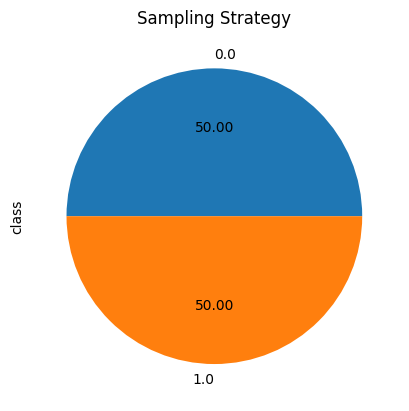

In [3]:
plots.sampling(results=results, path='./output/')

#### Feature Importance

`plots.feature_importance()` Creates a bar plot of important features with their feature contribution.

Saving feature importance plot to ./output//Feature Importance_1678536489930.png


'./output//Feature Importance_1678536489930.png'

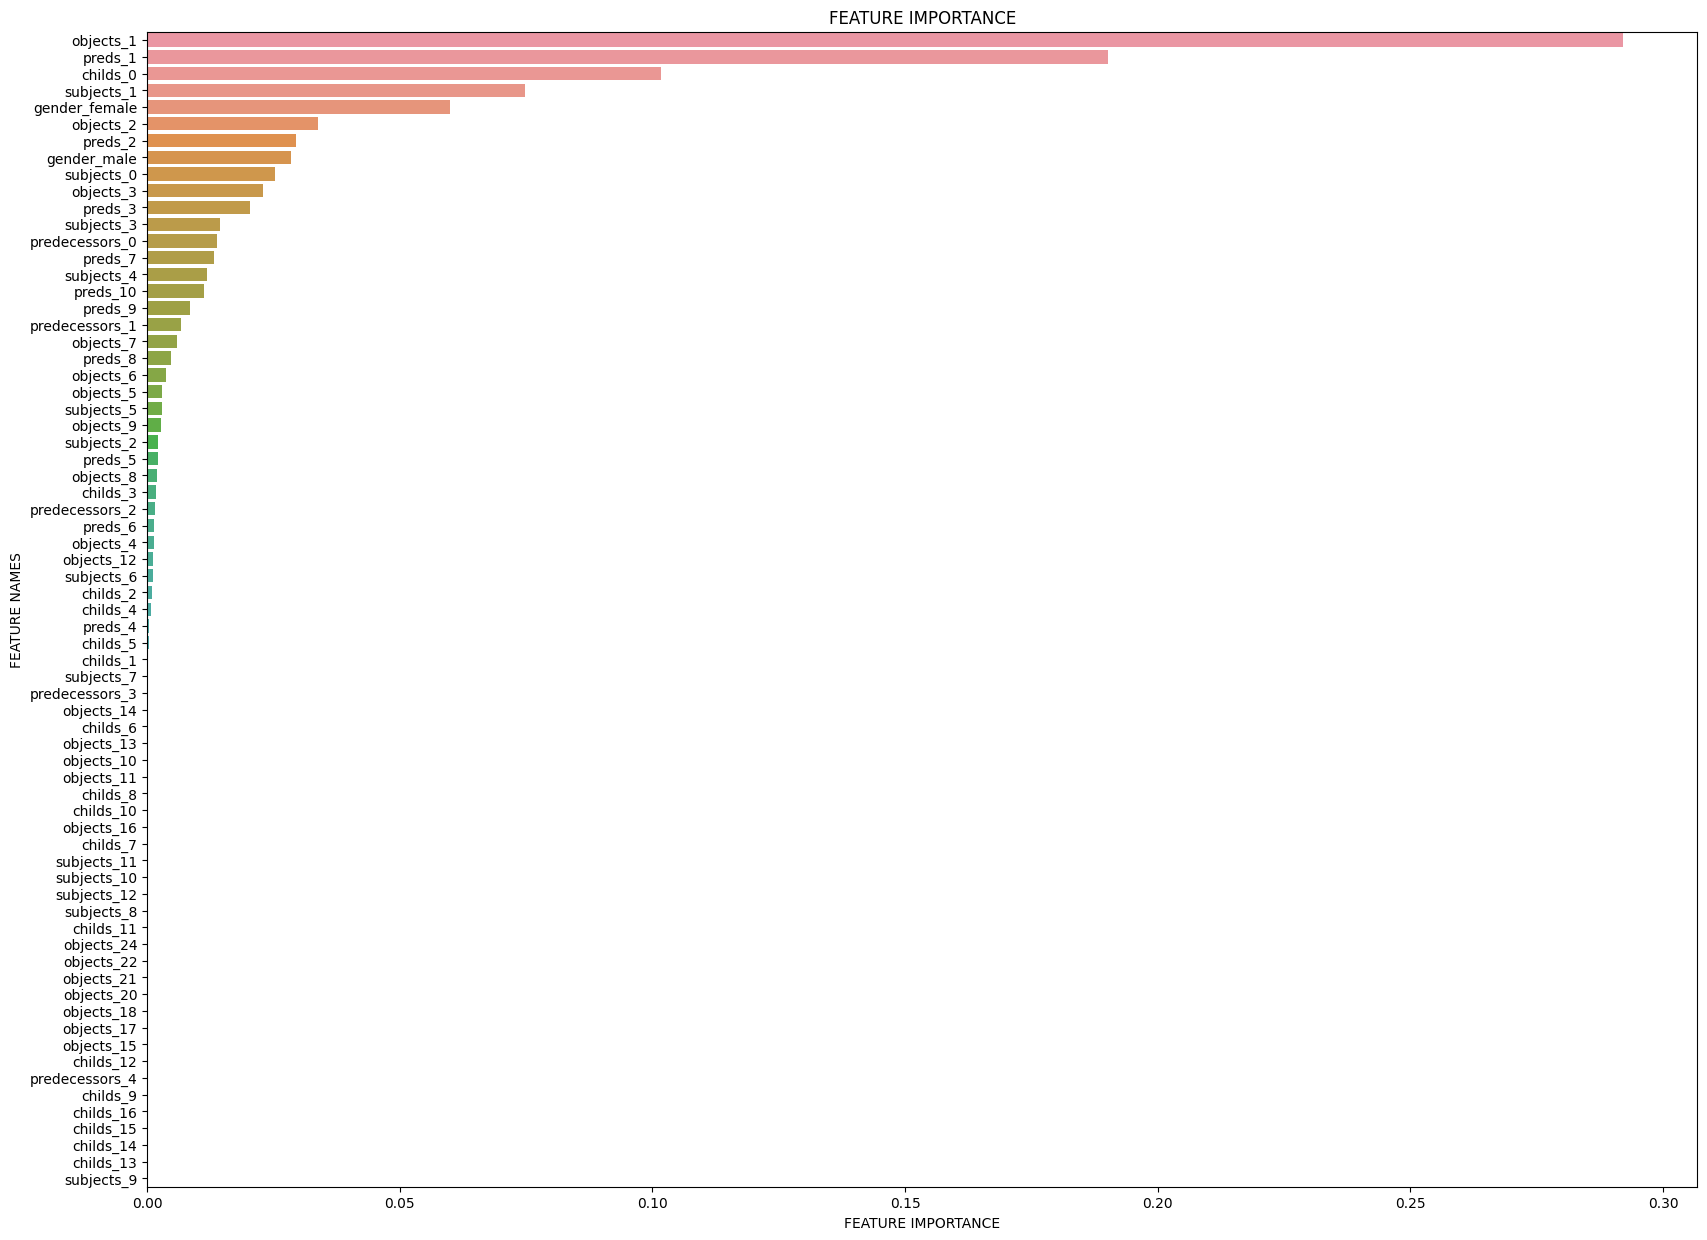

In [4]:
plots.feature_importance(results=results, path='./output/')

#### Decision Trees

To understand the trained predictive model's decisions, an automated model is deployed and a visualization of the prediction is performed via `plots.decision_trees()`. Here, the user can also visualize SHACL constraints with decision trees which shows entities violating the constraints/validating constraints via `plots.constraints_decision_trees()`.

Saving decision trees to ./output//Decision_trees_1678536489930.svg


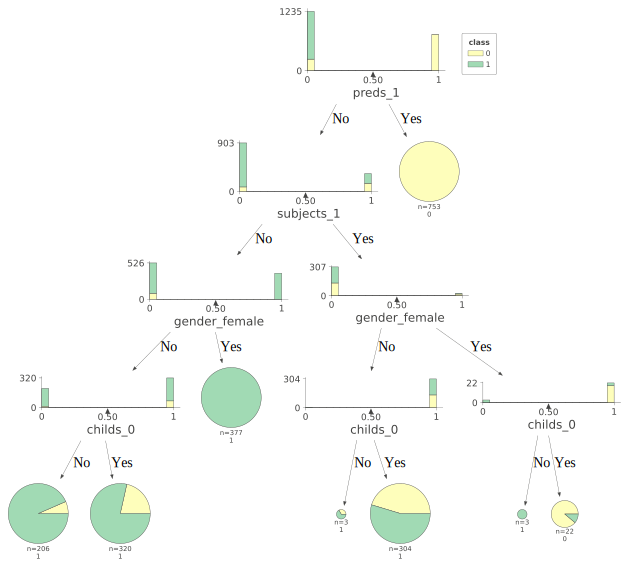

In [5]:
show_svg(plots.decision_trees(results=results, path='./output/'))

### Federated Query Processing

After uploading the semantified results to the InterpretME KG, [DeTrusty](https://github.com/SDM-TIB/DeTrusty) [3] is utilized to answer the user's questions via SPARQL queries over **both** the input KG and the *InterpretME KG*. In `./queries/french_royalty` you can find templates for answering the following questions:
1. Which is the target entity interpreted by LIME?
2. How does ***feature*** contribute to the classification of this entity in class ***class***
3. Which other features are relevant for this classification?
4. Does this target entity satisfy the domain integrity constraints?
5. What are the main characteristics of the target entity?

In [6]:
from InterpretME.federated_query_engine import federated

In [7]:
input_query = """
SELECT DISTINCT ?predicate ?object ?InterpretableTool ?feature ?value ?targetClass ?probability
WHERE {
    SERVICE <https://labs.tib.eu/sdm/InterpretME-wog/sparql> {
        FILTER( ?LIMEentity=<http://interpretme.org/entity/Louis_XIV> )
        ?entity a <http://interpretme.org/vocab/TargetEntity> .
        ?entity <http://www.w3.org/2002/07/owl#sameAs> ?sourceEntity .
        ?entity <http://interpretme.org/vocab/hasEntity> ?LIMEentity.
        ?entity <http://interpretme.org/vocab/hasInterpretedFeature> ?interpretedFeature .
        ?interpretedFeature <http://interpretme.org/vocab/hasFeatureWeight> ?featureWeight .
        ?interpretedFeature <http://www.w3.org/ns/prov#hasGeneratedBy> ?InterpretableTool .
        ?entity <http://interpretme.org/vocab/hasEntityClassProbability> ?classProb .
        ?classProb <http://interpretme.org/vocab/hasPredictionProbability> ?probability .
        ?classProb <http://interpretme.org/vocab/hasClass> ?targetClass .
        ?featureWeight <http://interpretme.org/vocab/hasFeature> ?feature .
        ?featureWeight <http://interpretme.org/vocab/hasWeight> ?value .
    }
    SERVICE <https://labs.tib.eu/sdm/InterpretME-og/sparql> {
        ?sourceEntity ?predicate ?object
    }
}
"""


In [8]:
query_answer = federated(input_query)

import pandas as pd
columns = query_answer['head']['vars']
df_result = pd.DataFrame(columns=columns)

cardinality = 0
for res in query_answer['results']['bindings']:
    df_result.loc[cardinality] = [res[var]['value'] for var in columns]
    cardinality += 1
df_result

#####################################################################
********************* Federated Query Engine ************************
#####################################################################
{'head': {'vars': ['predicate', 'object', 'InterpretableTool', 'feature', 'value', 'targetClass', 'probability']}, 'cardinality': 310, 'results': {'bindings': [{'predicate': {'value': 'http://www.w3.org/1999/02/22-rdf-syntax-ns#type', 'type': 'uri'}, 'object': {'value': 'http://dbpedia.org/ontology/Person', 'type': 'uri'}, 'InterpretableTool': {'value': 'http://interpretme.org/entity/LIME', 'type': 'uri'}, 'feature': {'value': 'http://interpretme.org/entity/childs_0%20%3C%3D%201.00', 'type': 'uri'}, 'value': {'value': '0.0', 'type': 'literal'}, 'targetClass': {'value': 'http://interpretme.org/entity/0', 'type': 'uri'}, 'probability': {'value': '0.0653595', 'type': 'literal'}, '__meta__': {'is_verified': True}}, {'predicate': {'value': 'http://www.w3.org/1999/02/22-rdf-syntax-ns#t

predicate  \
0    http://www.w3.org/1999/02/22-rdf-syntax-ns#type   
1    http://www.w3.org/1999/02/22-rdf-syntax-ns#type   
2    http://www.w3.org/1999/02/22-rdf-syntax-ns#type   
3    http://www.w3.org/1999/02/22-rdf-syntax-ns#type   
4    http://www.w3.org/1999/02/22-rdf-syntax-ns#type   
..                                               ...   
305          http://dbpedia.org/ontology/numSubjects   
306          http://dbpedia.org/ontology/numSubjects   
307          http://dbpedia.org/ontology/numSubjects   
308          http://dbpedia.org/ontology/numSubjects   
309          http://dbpedia.org/ontology/numSubjects   

                                 object                   InterpretableTool  \
0    http://dbpedia.org/ontology/Person  http://interpretme.org/entity/LIME   
1    http://dbpedia.org/ontology/Person  http://interpretme.org/entity/LIME   
2    http://dbpedia.org/ontology/Person  http://interpretme.org/entity/LIME   
3    http://dbpedia.org/ontology/Person  http://interpretme.org/entity/LIME   
4    http://dbpedia.org/ontology/Person  http://interpretme.org/entity/LIME   
..                                  ...                                 ...   
305                                   9  http://interpretme.org/entity/LIME   
306                                   9  http://interpretme.org/entity/LIME   
307                                   9  http://interpretme.org/entity/LIME   
308                                   9  http://interpretme.org/entity/LIME   
309                                   9  http://interpretme.org/entity/LIME   

                                               feature         value  \
0    http://interpretme.org/entity/childs_0%20%3C%3...           0.0   
1    http://interpretme.org/entity/childs_0%20%3C%3...           0.0   
2    http://interpretme.org/entity/gender_female%20...    -0.0292482   
3    http://interpretme.org/entity/gender_female%20...    -0.0292482   
4    http://interpretme.org/entity/objects_1%20%3C%...      0.749627   
..                                                 ...           ...   
305  http://interpretme.org/entity/objects_1%20%3C%...      0.749627   
306  http://interpretme.org/entity/preds_1%20%3C%3D...  -0.000241988   
307  http://interpretme.org/entity/preds_1%20%3C%3D...  -0.000241988   
308  http://interpretme.org/entity/subjects_1%20%3C...      0.207415   
309  http://interpretme.org/entity/subjects_1%20%3C...      0.207415   

                         targetClass probability  
0    http://interpretme.org/entity/0   0.0653595  
1    http://interpretme.org/entity/1    0.934641  
2    http://interpretme.org/entity/1    0.934641  
3    http://interpretme.org/entity/0   0.0653595  
4    http://interpretme.org/entity/0   0.0653595  
..                               ...         ...  
305  http://interpretme.org/entity/1    0.934641  
306  http://interpretme.org/entity/0   0.0653595  
307  http://interpretme.org/entity/1    0.934641  
308  http://interpretme.org/entity/0   0.0653595  
309  http://interpretme.org/entity/1    0.934641  

[310 rows x 7 columns]

------------
**References**

[1] Marco Ribeiro, Sameer Singh, and Carlos Guestrin. "Why Should I Trust You?": Explaining the Predictions of Any Classifier. In: Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD '16). ACM. 2016. DOI: [10.1145/2939672.2939778](https://dl.acm.org/doi/10.1145/2939672.2939778).

[2] E. Iglesias, S. Jozashoori, D. Chaves-Fraga, D. Collarana and M.-E. Vidal. SDM-RDFizer: An RML Interpreter for the Efficient Creation of RDF Knowledge Graphs. In: CIKM ’20:Proceedings of the 29th ACM International Conference on Information & Knowledge Management, ACM, New York, NY,USA, 2020. DOI: [10.1145/3340531.3412881](https://dl.acm.org/doi/pdf/10.1145/3340531.3412881).

[3] P.D. Rohde. DeTrusty v0.11.1, February 2023. DOI: [10.5281/zenodo.7639170](https://doi.org/10.5281/zenodo.7639170).